## “In this part, we covered text processing for the Customer Remarks column, built the model, then tuned and saved it for further use.”

#### Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
# Train Test Split
from sklearn.model_selection import train_test_split

# ML models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

# Evaluation
from sklearn.metrics import accuracy_score, recall_score, classification_report, precision_score, f1_score, ConfusionMatrixDisplay,confusion_matrix, roc_curve, auc, RocCurveDisplay
import joblib

In [3]:
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,label_binarize
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from collections import Counter

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
customer = pd.read_csv('Customer.csv')

In [8]:
customer.head()

,Unnamed: 0,channel_name,category,Sub-category,Customer Remarks,Customer_City,Product_category,Tenure Bucket,Agent Shift,CSAT Score,...,Issue_reported_month,issue_responded_date,Survey_response_Date_date,Survey_response_Day_Name,Survey_response_Date_month,Issue_reported_time_minutes,issue_responded_time_minutes,Handling_Time_minutes,Agent Experience Level,Handling Bucket
0,0,Outcall,Product Queries,Life Insurance,NaN,Not Given,Not Available,On Job Training,Morning,5,...,August,2023-08-01,2023-08-01,Tuesday,August,6.513230,6.562444,3.555348,New,Medium
1,1,Outcall,Product Queries,Product Specific Information,NaN,Not Given,Not Available,>90,Morning,5,...,August,2023-08-01,2023-08-01,Tuesday,August,6.650279,6.652863,1.098612,Experienced,Quick
2,2,Inbound,Order Related,Installation/demo,NaN,Not Given,Not Available,On Job Training,Evening,5,...,August,2023-08-01,2023-08-01,Tuesday,August,7.104144,7.122060,3.135494,New,Medium
3,3,Inbound,Returns,Reverse Pickup Enquiry,NaN,Not Given,Not Available,>90,Evening,5,...,August,2023-08-01,2023-08-01,Tuesday,August,7.136483,7.152269,3.044522,Experienced,Quick
4,4,Inbound,Cancellation,Not Needed,NaN,Not Given,Not Available,0-30,Morning,5,...,August,2023-08-01,2023-08-01,Tuesday,August,6.447306,6.450470,1.098612,New,Quick


In [11]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    85907 non-null  int64  
 1   channel_name                  85907 non-null  object 
 2   category                      85907 non-null  object 
 3   Sub-category                  85907 non-null  object 
 4   Customer Remarks              28742 non-null  object 
 5   Customer_City                 85907 non-null  object 
 6   Product_category              85907 non-null  object 
 7   Tenure Bucket                 85907 non-null  object 
 8   Agent Shift                   85907 non-null  object 
 9   CSAT Score                    85907 non-null  int64  
 10  Issue_reported_date           85907 non-null  object 
 11  Issue_reported_day_Name       85907 non-null  object 
 12  Issue_reported_month          85907 non-null  object 
 13  i

In [13]:
# Replace missing remarks with a placeholder (or empty string)
customer['Customer Remarks'] = customer['Customer Remarks'].fillna("")


In [15]:
import re

def clean_text(text):
    text = text.lower()                            # lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)        # remove punctuation/special characters
    text = re.sub(r'\s+', ' ', text).strip()       # remove extra whitespace
    return text

customer['Customer_Remarks'] = customer['Customer Remarks'].apply(clean_text)


In [16]:
# Step 1: Cleaning the  Target
customer = customer[customer['CSAT Score'].between(1, 5)]
customer['CSAT Score'] = customer['CSAT Score'].astype(int)

# Step 2: TF-IDF on Cleaned Remarks
tfidf = TfidfVectorizer(max_features=200, ngram_range=(1, 2))
remarks_tfidf = tfidf.fit_transform(customer['Customer_Remarks'].fillna(''))

remarks_df = pd.DataFrame(
    remarks_tfidf.toarray(),
    columns=tfidf.get_feature_names_out()
)

# Save TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Step 3: Merge TF-IDF with other features
customer = customer.drop(columns=['Customer_Remarks'])
customer = pd.concat([customer, remarks_df], axis=1)

In [18]:
customer

,Unnamed: 0,channel_name,category,Sub-category,Customer Remarks,Customer_City,Product_category,Tenure Bucket,Agent Shift,CSAT Score,...,why,will,with,with the,work,worst,wrong,you,you so,your
0,0,Outcall,Product Queries,Life Insurance,,Not Given,Not Available,On Job Training,Morning,5,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Outcall,Product Queries,Product Specific Information,,Not Given,Not Available,>90,Morning,5,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Inbound,Order Related,Installation/demo,,Not Given,Not Available,On Job Training,Evening,5,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Inbound,Returns,Reverse Pickup Enquiry,,Not Given,Not Available,>90,Evening,5,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Inbound,Cancellation,Not Needed,,Not Given,Not Available,0-30,Morning,5,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85902,85902,Inbound,Refund Related,Refund Enquiry,,Not Given,Not Available,On Job Training,Morning,4,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85903,85903,Inbound,Order Related,Seller Cancelled Order,Supported team customer executive good,Not Given,Not Available,>90,Morning,5,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85904,85904,Inbound,Order Related,Order status enquiry,need to improve with proper details.,Not Given,Not Available,On Job Training,Evening,5,...,0.0,0.0,0.438431,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85905,85905,Inbound,Feedback,UnProfessional Behaviour,,Not Given,Not Available,>90,Morning,4,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
customer['Customer Remarks'].value_counts(normalize=True)

Customer Remarks
                                         0.665429
Good                                     0.016180
Good                                     0.013480
Very good                                0.006623
Nice                                     0.003678
                                           ...   
Please get Malayalam call assistance     0.000012
Happy bahat khusi hua                    0.000012
My problem didn't solved                 0.000012
Thanks to filpkard team                  0.000012
need to improve with proper details.     0.000012
Name: proportion, Length: 18232, dtype: float64

#### This is the spread of the remarks given by the users

In [20]:
customer.head()

,Unnamed: 0,channel_name,category,Sub-category,Customer Remarks,Customer_City,Product_category,Tenure Bucket,Agent Shift,CSAT Score,...,why,will,with,with the,work,worst,wrong,you,you so,your
0,0,Outcall,Product Queries,Life Insurance,,Not Given,Not Available,On Job Training,Morning,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Outcall,Product Queries,Product Specific Information,,Not Given,Not Available,>90,Morning,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Inbound,Order Related,Installation/demo,,Not Given,Not Available,On Job Training,Evening,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Inbound,Returns,Reverse Pickup Enquiry,,Not Given,Not Available,>90,Evening,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Inbound,Cancellation,Not Needed,,Not Given,Not Available,0-30,Morning,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


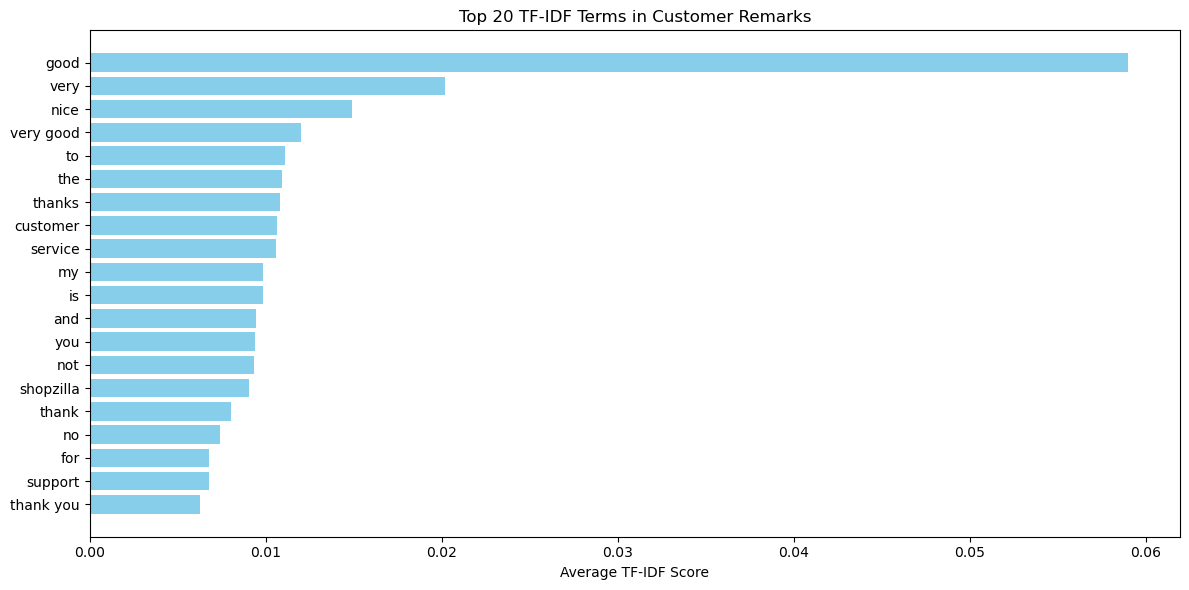

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Get top 20 mean TF-IDF scores across all documents
mean_tfidf = np.asarray(remarks_tfidf.mean(axis=0)).flatten()
top_n = 20
top_indices = mean_tfidf.argsort()[::-1][:top_n]
top_words = [tfidf.get_feature_names_out()[i] for i in top_indices]
top_scores = mean_tfidf[top_indices]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_words[::-1], top_scores[::-1], color='skyblue')
plt.xlabel("Average TF-IDF Score")
plt.title("Top 20 TF-IDF Terms in Customer Remarks")
plt.tight_layout()
plt.show()


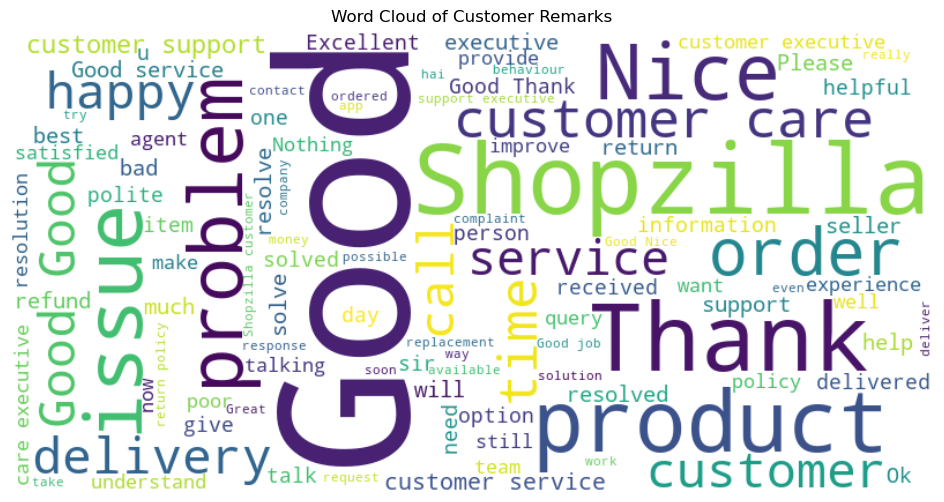

In [26]:
from wordcloud import WordCloud

# Combine all remarks into one string
all_remarks = " ".join(customer['Customer Remarks'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=100, colormap='viridis').generate(all_remarks)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Customer Remarks")
plt.show()


In [27]:
customer.head()

,Unnamed: 0,channel_name,category,Sub-category,Customer Remarks,Customer_City,Product_category,Tenure Bucket,Agent Shift,CSAT Score,...,why,will,with,with the,work,worst,wrong,you,you so,your
0,0,Outcall,Product Queries,Life Insurance,,Not Given,Not Available,On Job Training,Morning,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Outcall,Product Queries,Product Specific Information,,Not Given,Not Available,>90,Morning,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Inbound,Order Related,Installation/demo,,Not Given,Not Available,On Job Training,Evening,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Inbound,Returns,Reverse Pickup Enquiry,,Not Given,Not Available,>90,Evening,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Inbound,Cancellation,Not Needed,,Not Given,Not Available,0-30,Morning,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
customer.columns

Index(['Unnamed: 0', 'channel_name', 'category', 'Sub-category',
       'Customer Remarks', 'Customer_City', 'Product_category',
       'Tenure Bucket', 'Agent Shift', 'CSAT Score',
       ...
       'why', 'will', 'with', 'with the', 'work', 'worst', 'wrong', 'you',
       'you so', 'your'],
      dtype='object', length=222)

In [29]:
from imblearn.over_sampling import RandomOverSampler

In [31]:
X = customer.drop(columns=['CSAT Score'])
y = customer['CSAT Score']

In [32]:
# ----------------  Identify Feature Types -------
cat_high_card = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() > 30]
cat_low_card  = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() <= 30]
num_features  = X.select_dtypes(include=np.number).columns.tolist()

# ----------------  Binary Encode High-Card Columns -------
binary_encoder = BinaryEncoder(cols=cat_high_card, drop_invariant=True)
X_encoded = binary_encoder.fit_transform(X)

#  Save encoder
joblib.dump(binary_encoder, "binary_encoder.pkl")

# ----------------  Preprocess Remaining Features ----
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_low_card),
    ("scale", StandardScaler(), num_features)
], remainder='passthrough', verbose_feature_names_out=False)

X_final = preprocessor.fit_transform(X_encoded)

#  Save preprocessor
joblib.dump(preprocessor, "preprocessor.pkl")

# ----------------  Apply SMOTETomek -----------------
rs = RandomOverSampler(random_state=42)
X_resampled, y_resampled = rs.fit_resample(X_final, y)

# ---------------- Split Dataset -------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# ----------------  Output Summary ------------------
print(" Full pipeline with TF-IDF complete!")
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

 Full pipeline with TF-IDF complete!
Train shape: (178851, 299)
Validation shape: (59617, 299)
Test shape: (59617, 299)


In [79]:
from tqdm import tqdm # To estimate the time

#### Model 1 Random Forest Classifier

In [96]:
model =  RandomForestClassifier(n_estimators=200,class_weight='balanced', random_state=42)
for name in tqdm(['RandomForest'],desc='Training',position=0):
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


Training: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [06:47<00:00, 407.75s/it]

              precision    recall  f1-score   support

           1       0.92      0.98      0.95     11924
           2       1.00      1.00      1.00     11923
           3       0.99      1.00      1.00     11923
           4       0.92      0.98      0.95     11924
           5       0.96      0.82      0.89     11923

    accuracy                           0.96     59617
   macro avg       0.96      0.96      0.96     59617
weighted avg       0.96      0.96      0.96     59617



In [97]:
evaluation_dict_model_1 = {
    'Model Name': 'model_1',
    'Model Type': 'RandomForestClassifier',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'Precision': precision_score(y_test,y_pred, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred, average='weighted')
}
evaluation_df_model_1 = pd.DataFrame(evaluation_dict_model_1, index=[0])

# Output the DataFrame
evaluation_df_model_1

,Model Name,Model Type,Accuracy,Recall,Precision,F1-Score
0,model_1,RandomForestClassifier,0.956573,0.956573,0.957609,0.955588


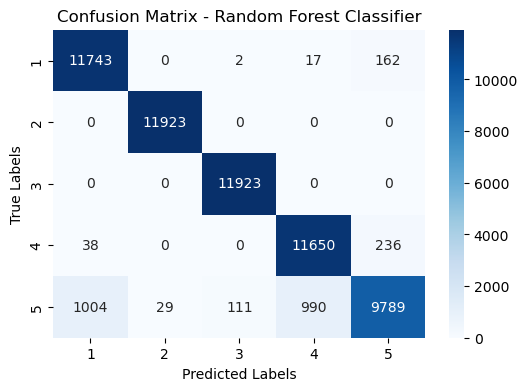

In [98]:
cmatrix = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cmatrix,annot=True,fmt='d',cmap='Blues',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

            

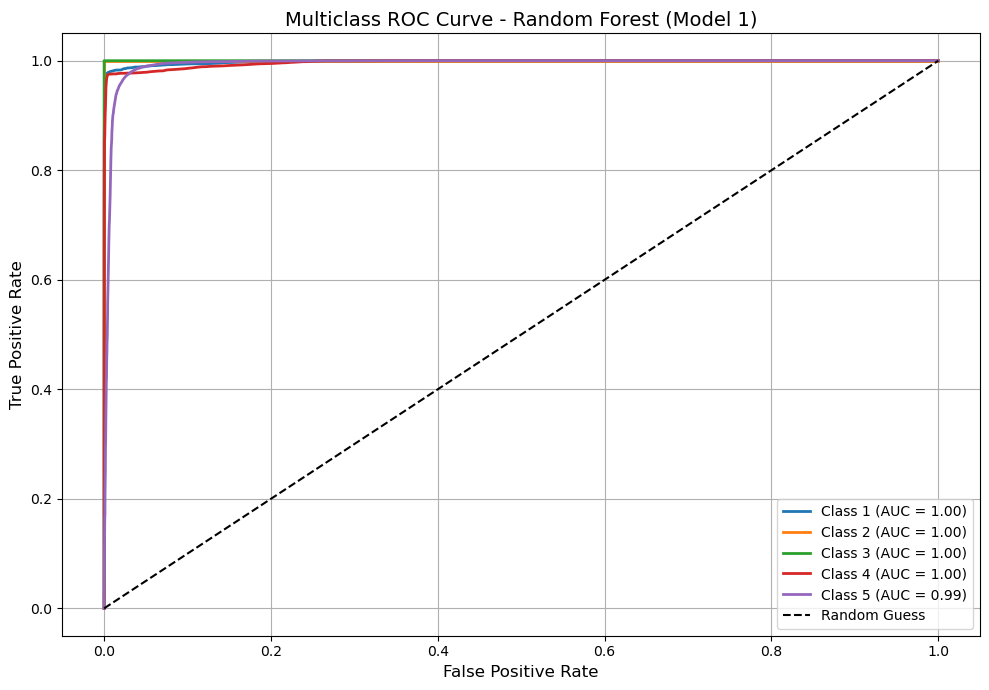

In [99]:
# --- Binarize output labels for multiclass ROC ---
classes = sorted(np.unique(y_test))
n_classes = len(classes)
y_test_binarized = label_binarize(y_test, classes=classes)

# --- Predict probabilities for each class ---
y_score = model.predict_proba(X_test)

# --- Initialize plot ---
plt.figure(figsize=(10, 7))
colors = sns.color_palette("tab10", n_classes)

# --- Plot ROC curve for each class ---
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i],
             label=f"Class {class_label} (AUC = {roc_auc:.2f})")

# --- Plot diagonal reference line (random guess) ---
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Guess')

# --- Labeling and layout ---
plt.title('Multiclass ROC Curve - Random Forest (Model 1)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
joblib.dump(model,'Random_Forest.pkl',compress=7)

['Random_Forest.pkl']

#### Model 2 DecisionTreeClassifier

In [60]:
model_2 = DecisionTreeClassifier(criterion='gini',class_weight='balanced',random_state=42)
for name in tqdm(['DecisionTreeClassifier'],desc='Training',position=0):
     model_2.fit(X_train,y_train)

Training: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.47s/it]


In [86]:
model_2_pred = model_2.predict(X_test)
print(classification_report(y_test, model_2_pred))

              precision    recall  f1-score   support

           1       0.87      0.98      0.92     11924
           2       0.98      1.00      0.99     11923
           3       0.95      1.00      0.98     11923
           4       0.84      0.98      0.90     11924
           5       0.96      0.61      0.75     11923

    accuracy                           0.91     59617
   macro avg       0.92      0.91      0.91     59617
weighted avg       0.92      0.91      0.91     59617



In [88]:
# Create a dictionary for evaluation metrics
evaluation_dict_model_2 = {
    'Model Name': 'model_2',
    'Model Type': 'DecisionTreeClassifier',
    'Accuracy': accuracy_score(y_test, model_2_pred),
    'Recall': recall_score(y_test, model_2_pred, average='weighted'),  # Use 'weighted' for multiclass
    'Precision': precision_score(y_test, model_2_pred, average='weighted'),  # Use 'weighted' for multiclass
    'F1-Score': f1_score(y_test, model_2_pred, average='weighted')  # Use 'weighted' for multiclass
}

# Convert the dictionary into a DataFrame
evaluation_df = pd.DataFrame(evaluation_dict_model_2, index=[0])

# Output the DataFrame
evaluation_df

,Model Name,Model Type,Accuracy,Recall,Precision,F1-Score
0,model_2,DecisionTreeClassifier,0.914018,0.914018,0.920461,0.90743


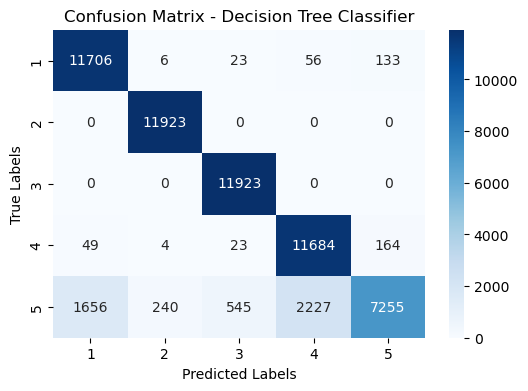

In [90]:
cmatrix = confusion_matrix(y_test,model_2_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cmatrix,annot=True,fmt='d',cmap='Blues',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

            

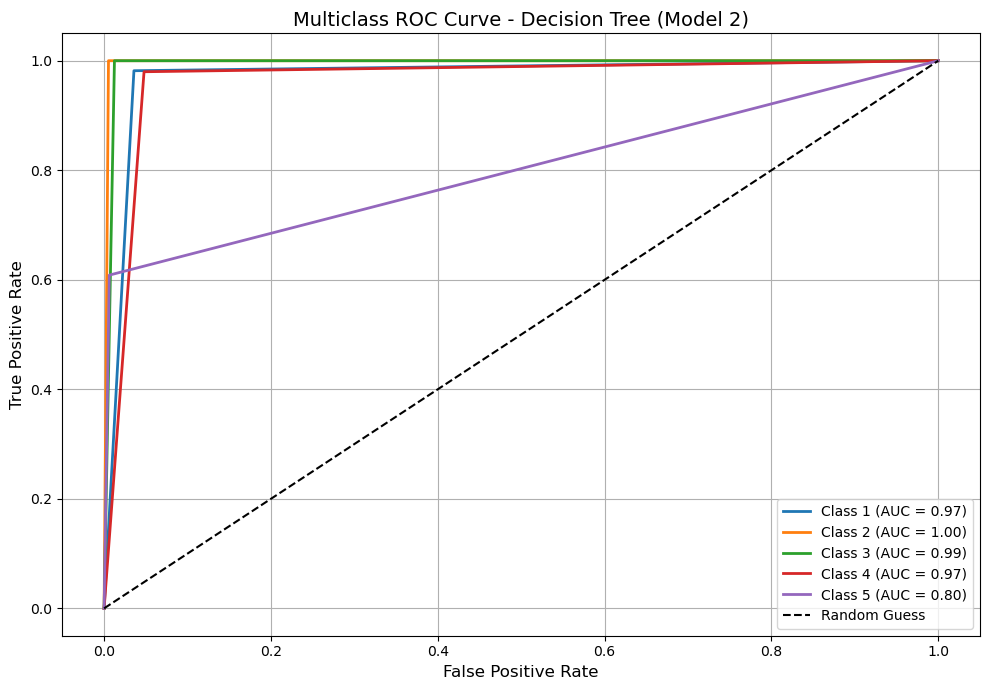

In [92]:
# --- Binarize output labels for multiclass ROC ---
classes = sorted(np.unique(y_test))
n_classes = len(classes)
y_test_binarized = label_binarize(y_test, classes=classes)

# --- Predict probabilities for each class ---
y_score = model_2.predict_proba(X_test)

# --- Initialize plot ---
plt.figure(figsize=(10, 7))
colors = sns.color_palette("tab10", n_classes)

# --- Plot ROC curve for each class ---
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i],
             label=f"Class {class_label} (AUC = {roc_auc:.2f})")

# --- Plot diagonal reference line (random guess) ---
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Guess')

# --- Labeling and layout ---
plt.title('Multiclass ROC Curve - Decision Tree (Model 2)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Model 3 HistGradientBoostingClassifier

In [73]:
model_3 = HistGradientBoostingClassifier()
for name in tqdm(['HistGradientBoostingClassifier'],desc='Training',position=0):
    model_3.fit(X_train, y_train)

Training: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [02:16<00:00, 136.53s/it]


In [94]:
model_3_pred = model_3.predict(X_test)

In [100]:

# Create a dictionary for evaluation metrics
evaluation_dict = {
    'Model Name': 'model_3',
    'Model Type': ' HistGradient Boosting Classifier',
    'Accuracy': accuracy_score(y_test, model_3_pred),
    'Recall': recall_score(y_test, model_3_pred, average='weighted'),  # Use 'weighted' for multiclass
    'Precision': precision_score(y_test, model_3_pred, average='weighted'),  # Use 'weighted' for multiclass
    'F1-Score': f1_score(y_test, model_3_pred, average='weighted')  # Use 'weighted' for multiclass
}

# Convert the dictionary into a DataFrame
evaluation_df = pd.DataFrame(evaluation_dict, index=[0])

# Output the DataFrame
evaluation_df

,Model Name,Model Type,Accuracy,Recall,Precision,F1-Score
0,model_3,HistGradient Boosting Classifier,0.566432,0.566432,0.576359,0.568167


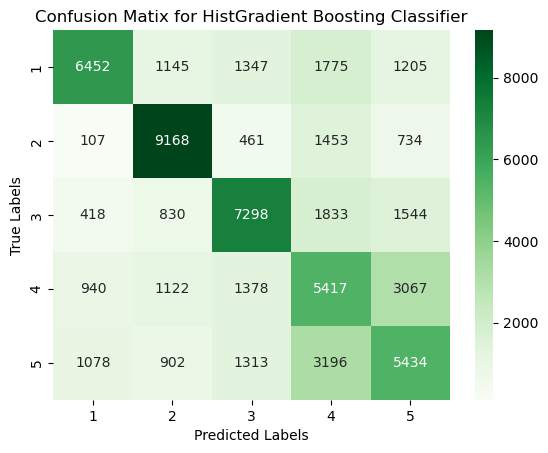

In [101]:
c_matrix = confusion_matrix(y_test,model_3_pred)
sns.heatmap(c_matrix,annot=True,fmt='d',cmap='Greens',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matix for HistGradient Boosting Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

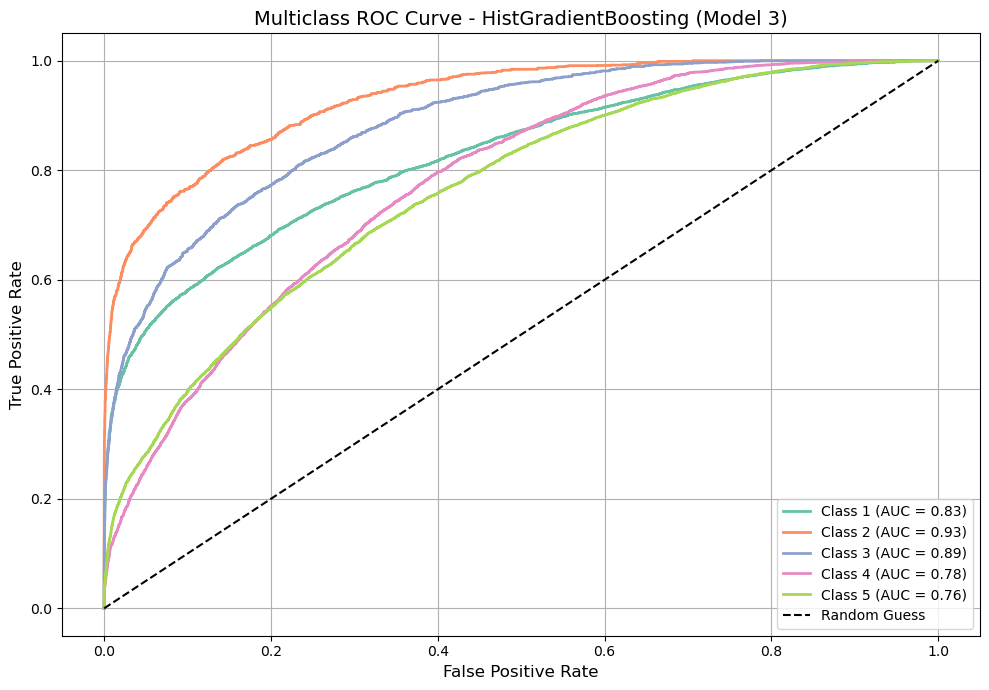

In [102]:
# Binarize the labels for multiclass ROC
classes = sorted(np.unique(y_test))
n_classes = len(classes)
y_test_binarized = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score = model_3.predict_proba(X_test)

# Initialize the plot
plt.figure(figsize=(10, 7))
colors = sns.color_palette("Set2", n_classes)  # Use Set2 for pastel color variety

# Plot ROC curve per class
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

# Plot diagonal baseline (random guess)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label="Random Guess")

# Customize plot
plt.title("Multiclass ROC Curve - HistGradientBoosting (Model 3)", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Model 4 AdaBoostClassifier

In [110]:
#Implementation
model_4 =  AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
for name in tqdm(['AdaBoostClassifier'],desc='Training',position=0):
        # Fit the Model
    model_4.fit(X_train, y_train)

Training: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [11:08<00:00, 668.79s/it]


In [111]:
# Predict on the model
model_4_pred = model_4.predict(X_test)

In [121]:

# Create a dictionary for evaluation metrics
evaluation_dict = {
    'Model Name': 'model_4',
    'Model Type': 'AdaBoostClassifier',
    'Accuracy': accuracy_score(y_test, model_4_pred),
    'Recall': recall_score(y_test, model_4_pred, average='weighted'),  # Use 'weighted' for multiclass
    'Precision': precision_score(y_test, model_4_pred, average='weighted'),  # Use 'weighted' for multiclass
    'F1-Score': f1_score(y_test, model_4_pred, average='weighted')  # Use 'weighted' for multiclass
}

# Convert the dictionary into a DataFrame
evaluation_df = pd.DataFrame(evaluation_dict, index=[0])

# Output the DataFrame
evaluation_df

,Model Name,Model Type,Accuracy,Recall,Precision,F1-Score
0,model_4,AdaBoostClassifier,0.282084,0.282084,0.252989,0.245369


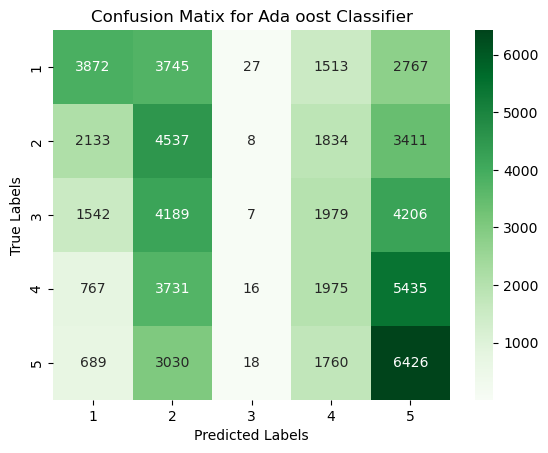

In [123]:
c_matrix = confusion_matrix(y_test,model_4_pred)
sns.heatmap(c_matrix,annot=True,fmt='d',cmap='Greens',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matix for Ada oost Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

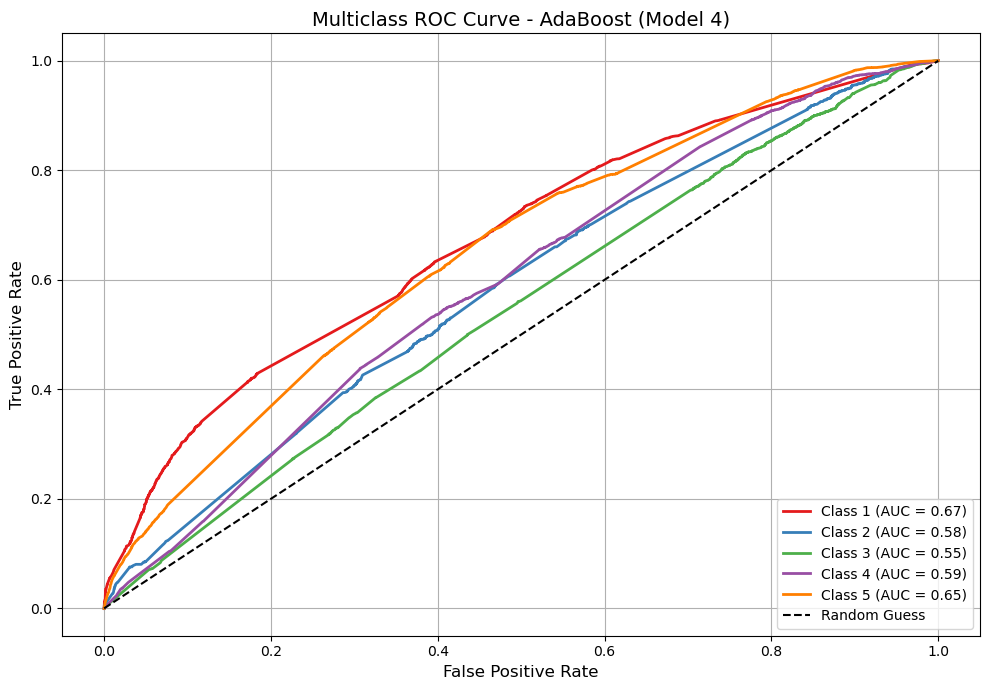

In [124]:
# Binarize the labels for multiclass ROC
classes = sorted(np.unique(y_test))
n_classes = len(classes)
y_test_binarized = label_binarize(y_test, classes=classes)

# Predict class probabilities
y_score = model_4.predict_proba(X_test)

# Initialize the plot
plt.figure(figsize=(10, 7))
colors = sns.color_palette("Set1", n_classes)  # Use a vibrant palette

# Plot ROC curve for each class
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f"Class {class_label} (AUC = {roc_auc:.2f})")

# Diagonal for random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label="Random Guess")

# Plot styling
plt.title("Multiclass ROC Curve - AdaBoost (Model 4)", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Model 5 KNeighborsClassifier

In [132]:
model5 = KNeighborsClassifier()
for name in tqdm(['KNeighborsClassifier'],desc='Training',position=0):
    model5.fit(X_train,y_train)
    model5_pred = model5.predict(X_test)

Training: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [03:36<00:00, 216.07s/it]


In [133]:
# Create a dictionary for evaluation metrics 
evaluation_dict_model5 = {
    'Model Name': 'model5',
    'Model Type': 'KNeighborsClassifier  ',
    'Accuracy': accuracy_score(y_test, model5_pred),
    'Recall': recall_score(y_test, model5_pred, average='weighted'),
    'Precision': precision_score(y_test, model5_pred, average='weighted'),
    'F1-Score': f1_score(y_test, model5_pred, average='weighted')
}

# Convert the dictionary into a DataFrame for easy visualization
evaluation_dict_model5 = pd.DataFrame(evaluation_dict_model5, index=[0])

# Output the DataFrame
evaluation_dict_model5

,Model Name,Model Type,Accuracy,Recall,Precision,F1-Score
0,model5,KNeighborsClassifier,0.801969,0.801969,0.794976,0.785624


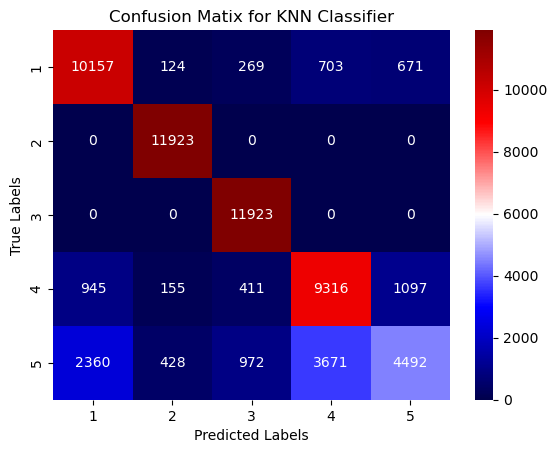

In [134]:
c_matrix = confusion_matrix(y_test,model5_pred)
sns.heatmap(c_matrix,annot=True,fmt='d',cmap='seismic',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matix for KNN Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

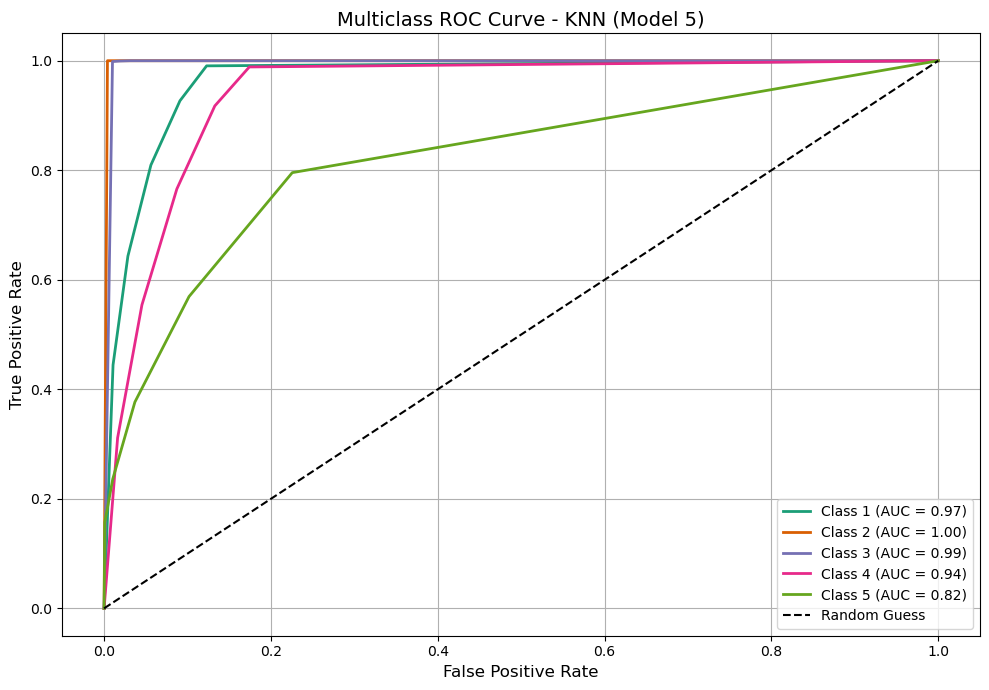

In [135]:
# --- Binarize the output labels for multiclass ROC ---
classes = sorted(np.unique(y_test))
n_classes = len(classes)
y_test_binarized = label_binarize(y_test, classes=classes)

# --- Predict probabilities for each class ---
y_score = model5.predict_proba(X_test)

# --- Initialize ROC plot ---
plt.figure(figsize=(10, 7))
colors = sns.color_palette("Dark2", n_classes)  # Use Dark2 for diversity

# --- Plot ROC curve for each class ---
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i],
             label=f"Class {class_label} (AUC = {roc_auc:.2f})")

# --- Plot diagonal line for random guess ---
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label="Random Guess")

# --- Labels and layout ---
plt.title("Multiclass ROC Curve - KNN (Model 5)", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Hyper Parameter Tuning
## Let's tune the RandomForest Model

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

In [43]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Generate all combinations
param_list = list(ParameterGrid(param_grid))
best_score = 0
best_model = None
best_params = None

print(f"Total combinations to try: {len(param_list)}")

# Progress bar with tqdm
for params in tqdm(param_list, desc="Tuning Random Forest"):
    rf = RandomForestClassifier(random_state=42, **params)
    rf.fit(X_train, y_train)
    val_score = rf.score(X_val, y_val)  # Assuming X_val/y_val exist

    if val_score > best_score:
        best_score = val_score
        best_model = rf
        best_params = params

# Evaluate best model
y_pred_rf = best_model.predict(X_test)

rf_eval_dict = {
    'Model': 'Random Forest (Tuned)',
    "Accuracy: ": accuracy_score(y_test, y_pred_rf),
    "Precision: ": precision_score(y_test, y_pred_rf, average='weighted'),
    "Recall: ": recall_score(y_test, y_pred_rf, average='weighted'),
    'F1-Score: ': f1_score(y_test, y_pred_rf, average='weighted')
}
rf_eval_df = pd.DataFrame([rf_eval_dict])

print("\nBest Parameters Found:")
print(best_params)
display(rf_eval_df)

Total combinations to try: 48


Tuning Random Forest: 100%|█████████████████████████████████████████████████████████| 48/48 [2:37:04<00:00, 196.35s/it]



Best Parameters Found:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


,Model,Accuracy:,Precision:,Recall:,F1-Score:
0,Random Forest (Tuned),0.969505,0.969577,0.969505,0.969183


In [45]:
train_score = rf.score(X_train, y_train)
print(f"Training Accuracy: {train_score:.4f} | Validation Accuracy: {val_score:.4f}")


Training Accuracy: 0.9950 | Validation Accuracy: 0.9391


In [68]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(best_model, X_train, y_train, cv=5)
# print("CV Accuracy:", scores.mean())


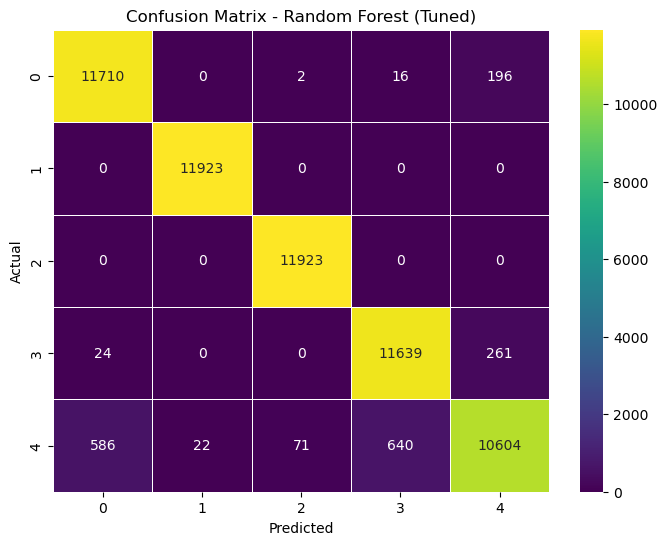

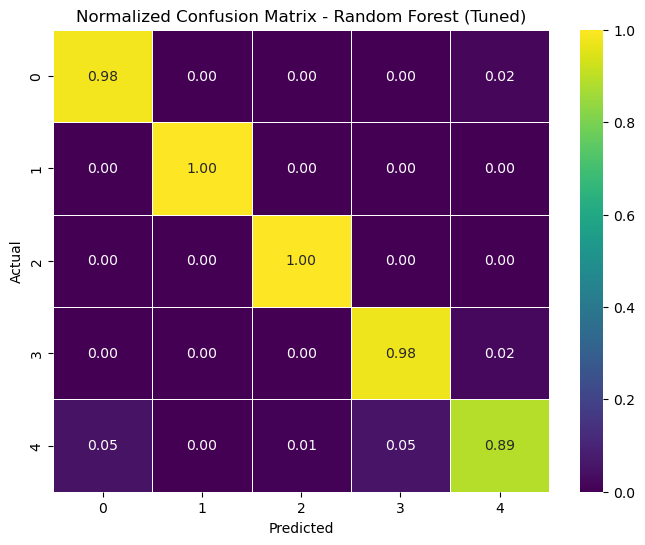

In [63]:
import seaborn as sns
#  Computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
cm_normalized = confusion_matrix(y_test, y_pred_rf, normalize='true')  # row-wise normalization

# Ploting the regular confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', linewidths=0.5)
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#  Ploting the  normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='viridis', linewidths=0.5)
plt.title('Normalized Confusion Matrix - Random Forest (Tuned)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

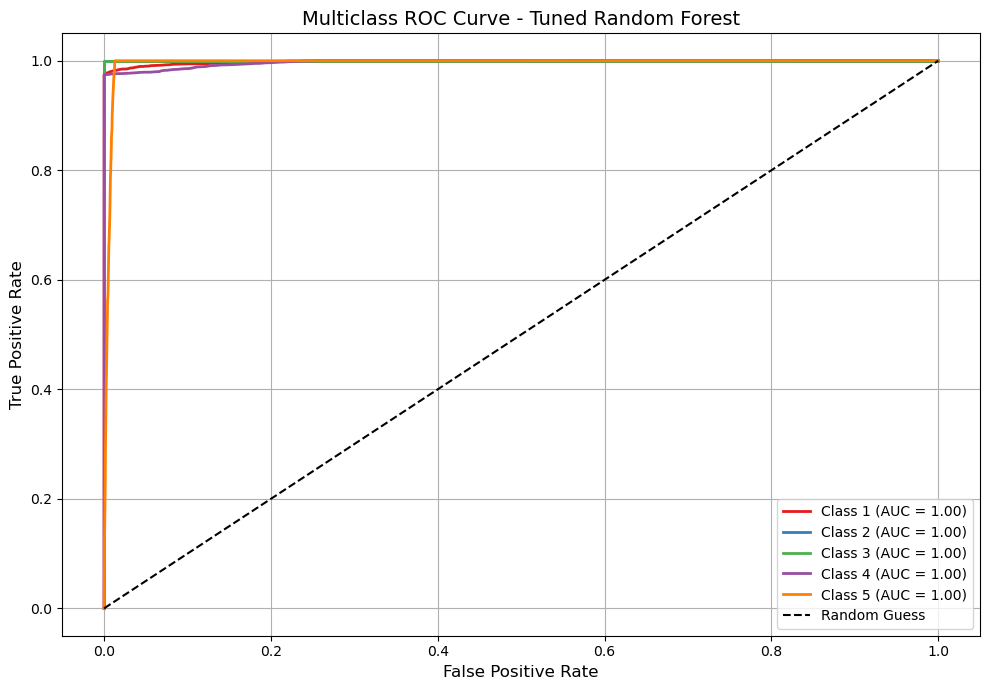

In [65]:
# Binarize the test labels (for multiclass ROC)
classes = sorted(np.unique(y_test))
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score = best_model.predict_proba(X_test)

# Initialize the plot
plt.figure(figsize=(10, 7))
colors = sns.color_palette("Set1", n_classes)  # You can use Set2, Dark2, etc.

# Plot ROC curve for each class
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i],
             label=f"Class {class_label} (AUC = {roc_auc:.2f})")

# Plot diagonal reference
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label="Random Guess")

# Format the plot
plt.title("Multiclass ROC Curve - Tuned Random Forest", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

## Compare the predicted values with the True Values after tuning

In [59]:
for i in range(11):
    true_label = y_test.iloc[i]
    probs = best_model.predict_proba(X_test[i:i+1])[0]
    pred = best_model.predict(X_test[i:i+1])[0]
    print(f"Sample {i}: True = {true_label}, Pred = {pred}, Probs = {dict(zip(best_model.classes_, np.round(probs, 2)))}")


Sample 0: True = 2, Pred = 2, Probs = {1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0, 5: 0.0}
Sample 1: True = 1, Pred = 1, Probs = {1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}
Sample 2: True = 2, Pred = 2, Probs = {1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0, 5: 0.0}
Sample 3: True = 4, Pred = 4, Probs = {1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0}
Sample 4: True = 3, Pred = 3, Probs = {1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 0.0}
Sample 5: True = 2, Pred = 2, Probs = {1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0, 5: 0.0}
Sample 6: True = 3, Pred = 3, Probs = {1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 0.0}
Sample 7: True = 5, Pred = 1, Probs = {1: 0.5, 2: 0.03, 3: 0.03, 4: 0.06, 5: 0.37}
Sample 8: True = 3, Pred = 3, Probs = {1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 0.0}
Sample 9: True = 1, Pred = 1, Probs = {1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}
Sample 10: True = 3, Pred = 3, Probs = {1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 0.0}


In [61]:
# To find the class distribution among the model(tuned)
preds = best_model.predict(X_val)
print(Counter(preds))


Counter({1: 12252, 4: 12184, 3: 11991, 2: 11937, 5: 11253})


## Saving the Tuned Model(RandomFoest)

In [67]:
# Saving the best model to a file
joblib.dump(best_model, 'random_forest_tuned_model.pkl',compress=8)
print('Model is Saved')

Model is Saved
